# OCR MNIST DIGITS - TENSORFLOW

The objective of this notebook is to make an OCR with a convnet in Tensorflow.
This is exercise is for learning purpose, so do not expect an optimized solution.
The data used shall be MNIST digits.

The problem is obtained from:

https://www.kaggle.com/c/digit-recognizer/data



# Import libraries:
Must install in jupyter:

pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension

otherwise remove tqdm_callbacks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

# Data

Data is in file "train.csv".

First column: label y (from 0->9)

Following 784 columns: pixels in order 28X28

Pixels range value: 0..255

## Import data:

In [2]:
data_train=(np.genfromtxt("train.csv", unpack=True, skip_header=1,delimiter=",")).T

## Normalization of data:

Usually in a Deep learning problem it is used: training data, cross-validation data and test data. Kaggle problem gives a specific set for test data that is used to check the full model.

Note that usually (for example in Tensorflow) in data matrix, the data is ordered: (training sample,data).

In [3]:
print("Full training data shape: (%d, %d)" % data_train.shape)

# NC: number of categories
NC=10

# NP: number of pixels in the image
NP=round((data_train.shape[1]-1)**0.5)

# Split data in train and cross validation
x_train, x_CV, y_train, y_CV = train_test_split(data_train[:,1:], (data_train[:,0]).reshape(-1,1), test_size=0.1, random_state=1)
# y is defined sparse categorical

# 90% training / 10% cross validation aprox.
m_train=x_train.shape[0]
m_CV=x_CV.shape[0]
print("Training data: ",m_train)
print("Cross Validation data: ",m_CV)

# Images data
### Normalization of x and reshaping
### Around each digit there is a black frame which can be removed. Cut gives the number of pixels removed from the frame.
cut=0
x_train=(x_train.reshape(m_train,NP,NP,1))/255.0
x_CV=(x_CV.reshape(m_CV,NP,NP,1))/255.0


print("x training data shape: (%d, %d, %d, %d)" % x_train.shape)
print("y training data shape: (%d, %d)" % y_train.shape)
print("x CV data shape: (%d, %d, %d, %d)" % x_CV.shape)
print("y CV data shape: (%d, %d)" % y_CV.shape)
print("Number of training data: %d" % m_train)
n_x=x_train.shape[1]*x_train.shape[2]
print("Number of features: %d" % n_x)
print("Images are: %d x %d" %(NP,NP))

Full training data shape: (42000, 785)
Training data:  37800
Cross Validation data:  4200
x training data shape: (37800, 28, 28, 1)
y training data shape: (37800, 1)
x CV data shape: (4200, 28, 28, 1)
y CV data shape: (4200, 1)
Number of training data: 37800
Number of features: 784
Images are: 28 x 28


## Understanding of the data:

Following picture is label as 2
(28, 28)


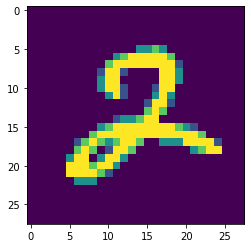

In [4]:
example2plot=1050
print("Following picture is label as %d" % y_train[example2plot,:])
example=(x_train[example2plot,:,:,0])
print(example.shape)
imgplot = plt.imshow(example)



# Tensorflow model
## Transfer learning from DenseNet121

In [5]:
IMG_SHAPE = (NP+4, NP+4, 3)
# Create the base model from the pre-trained model
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True


## Drop-out probability
drop_prob=0.5

## Lambda for L2 regularization
lambdaReg=0

inputs = tf.keras.layers.Input(shape = (NP,NP,1))

model=tf.keras.layers.ZeroPadding2D(padding=(2, 2))(inputs)

model = tf.keras.layers.Conv2D(3, (3,3),padding="same",kernel_regularizer=tf.keras.regularizers.l2(lambdaReg))(model)

model = base_model(model)

model = tf.keras.layers.Dropout(drop_prob)(model)

# Dense layers
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(256)(model)
model = tf.keras.layers.BatchNormalization()(model)
model = tf.keras.layers.ReLU()(model)

model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(256)(model)
model = tf.keras.layers.BatchNormalization()(model)
model = tf.keras.layers.ReLU()(model)
model = tf.keras.layers.Dropout(rate=drop_prob)(model)

model = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(model)
model = tf.keras.Model(inputs=inputs, outputs=model)


model.summary()

model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 3)         30        
_________________________________________________________________
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400

# Image generator

In [6]:
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    shear_range=10,
    rotation_range=10,
    fill_mode='constant',
    cval=0)

# Callbacks

In [7]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callback_earlyS = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7) 

tqdm_callbacks = tfa.callbacks.TQDMProgressBar()

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model run

In [8]:
batchsize=32
history=model.fit(datagen.flow(x_train, y_train, batch_size=batchsize),
                    steps_per_epoch=m_train / batchsize, epochs=100,validation_data = (x_CV, y_CV),verbose=0,
         callbacks=[learning_rate_reduction,callback_earlyS,model_checkpoint_callback,tqdm_callbacks])
model.load_weights(checkpoint_filepath)

  ...
    to  
  ['...']


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 00026: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 00029: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 30/100


To train with CV data as well (comment upward cell):

In [9]:
# Change patience of learning_rate_reduction to 1
# change all monitor in callbacks to 'accuracy'
'''batchsize=32
history=model.fit(datagen.flow(np.vstack((x_train,x_CV)), np.vstack((y_train,y_CV)), batch_size=batchsize),
                    steps_per_epoch=(m_train+m_CV) / batchsize, epochs=23, verbose=0,
         callbacks=[learning_rate_reduction,callback_earlyS,model_checkpoint_callback,tqdm_callbacks])
model.load_weights(checkpoint_filepath)'''

'batchsize=32\nhistory=model.fit(datagen.flow(np.vstack((x_train,x_CV)), np.vstack((y_train,y_CV)), batch_size=batchsize),\n                    steps_per_epoch=(m_train+m_CV) / batchsize, epochs=23, verbose=0,\n         callbacks=[learning_rate_reduction,callback_earlyS,model_checkpoint_callback,tqdm_callbacks])\nmodel.load_weights(checkpoint_filepath)'

# Print results

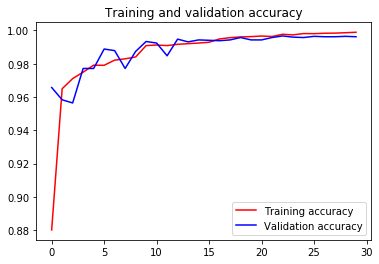

<Figure size 432x288 with 0 Axes>

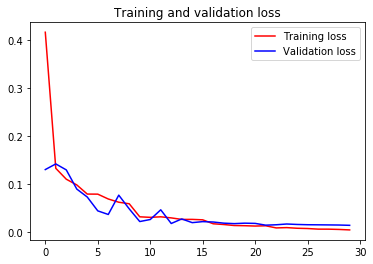

<Figure size 432x288 with 0 Axes>

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# Prediction for Kaggle competition

In [11]:
x_test=(np.genfromtxt("test.csv", unpack=True, skip_header=1,delimiter=",")).T
m_test=x_test.shape[0]
x_test=(x_test.reshape(m_test,NP,NP,1))/255.0
print("Shape of x_test is: (%d,%d,%d,%d)" %x_test.shape)

Shape of x_test is: (28000,28,28,1)


In [12]:
y_pred = model.predict(x_test)
cls_pred = np.argmax(y_pred, axis=1)

data = list(zip(list(range(1, 28001)), cls_pred))

submission_df = pd.DataFrame(data, columns=['ImageId','Label'])
submission_df.head()

submission_df.to_csv("Submission.csv",index=False)



# Obtained accuracy in KAGGLE: 0.99700
(training with train and CV data, not only with train)